# Using enterprise to analyze PTA data

In this notebook you will learn:
* How to use `enterprise` to interact with PTA data,
* How to search in PTA data for GWs,
* How to perform Bayesian model selection,
* How to post-process your results.

If you are interested in working through this notebook, but do not want to install the software, we have prepared a related Google Colab notebook: https://colab.research.google.com/drive/1xft6F9nyoEHUVn1LbW-0qgXiiKDJuR3X#scrollTo=7kVh83a8w36s

By copying this notebook, you can install the software to your own Google account and run the software without installation on your computer.

# Load modules

In [1]:
from __future__ import division

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

## Get par, tim, and noise files (this is not the preferred method when we have supplied pickled enterprise Pulsar files; see below)
Here we collect the tim and par files. 

In [2]:
psrlist = None # define a list of pulsar name strings that can be used to filter.

In [3]:
# some pathing to get to the data folder (this won't work if you change the parent folder name)
foldername = os.path.basename(os.getcwd())
if foldername != '12p5yr_stochastic_analysis':
    os.chdir(os.path.pardir)
datadir = os.path.join(os.getcwd(), 'data') # set your data directory
print(datadir)

/Users/aaronjohnson/Documents/GitHub/12p5yr_stochastic_analysis/data


In [4]:
single_pulsar = True

if single_pulsar:
    psrstring = 'J1909'  # name of the pulsar

    parfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'par'), psrstring + '*')))
    timfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'tim'), psrstring + '*')))
else:
    parfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'par'), '*par')))
    timfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'tim'), '*tim')))

# filter
if psrlist is not None:
    parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
    timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile... 
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv2.gls.par' not in x]

In [5]:
print(parfiles)

['/Users/aaronjohnson/Documents/GitHub/12p5yr_stochastic_analysis/data/par/J1909-3744_NANOGrav_12yv3.gls.par']


## Load into Pulsar class list

* The `enterprise` Pulsar class uses `libstempo` to read in `par` and `tim` files, then stores all pulsar data into a `Pulsar` object. This object contains all data and meta-data needed for the ensuing pulsar and PTA analysis. You no longer to reference the `par` and `tim` files after this cell.
* Note below that you can explicitly declare which version of the JPL solar-system ephemeris model that will be used to compute the Roemer delay between the geocenter and the barycenter (e.g. `DE438`). Otherwise the default values will be taken from the `par` files. Explicitly declaring the version here is good practice.
* You can also explicitly set the clock file to a version of `BIPM`, e.g. `BIPM(2018)`. This is less important, and you can let the code take the value from the `par` file.
* When you execute the following cell, you will get warnings like `WARNING: Could not find pulsar distance for PSR ...`. Don't worry! This is expected, and fine. Not all pulsars have well constrained distances, and will be set to `1 kpc` with a `20%` uncertainty.

### Read par and tim files into enterprise Pulsar objects

In [6]:
psrs = []
ephemeris = 'DE438'
for p, t in zip(parfiles, timfiles):
    psrname = parfiles[0].split('/')[-1].split('_')[0]
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)

## OR... load in enterprise pickled Pulsar instances that we've prepared!
Go here for full details: https://paper.dropbox.com/doc/NG-12.5yr_v3-GWB-Analysis--A2zJbxQU704Oq9jU1oqAWJCHAQ-DICJei6NxsPjxnO90mGMo

Pickled 12.5yr pulsars: https://drive.google.com/file/d/1GUcmdj9OMf7-hrAOydeHEO4ylQxgC9Kb/edit

Noise files: https://drive.google.com/file/d/1V7bu2y5hxFSj_7KWO3uNM7Q_0dciXfSX/edit

Empirical red noise proposal distributions: https://drive.google.com/file/d/19odsqZ93Wh8og1AGdU7SfvXzB0DJwipG/edit

In [ ]:
# some pathing to get to the data folder (this won't work if you change the parent folder name)
foldername = os.path.basename(os.getcwd())
if foldername != '12p5yr_stochastic_analysis':
    os.chdir(os.path.pardir)
datadir = os.path.join(os.getcwd(), 'data') # set your data directory
print(datadir)

# read in pickles
psrs = pickle.load(open(datadir + 'channelized_12yr_v3_partim_DE438.pkl', 'rb'))

* We can read-in some previously computed noise properties from single-pulsar analyses. These are things like `EFAC`, `EQUAD`, and (for `NANOGrav`) `ECORR`. 
* In practice, we set these white-noise properties as fixed in the low-frequency noise / GW searches.
* The noise properties have been stored as `json` files, and are read in to a big parameter dictionary.

In [8]:
## Get parameter noise dictionary
noise_ng12 = os.path.join(datadir, 'channelized_12p5yr_v3_full_noisedict.json')

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

In [ ]:
## Load in empirical distributions
#emp_dists = pickle.load(open(datadir + '12yr_emp_dist_RNonly_py3.pkl', 'rb'))
#emp_dists = '/home/stephen.taylor/NANOGrav/nanograv_12p5yr_analysis/nanograv_12p5yr_analysis_mar2020/data/12yr_emp_dist_RNonly_py3.pkl'

# PTA Parameter Estimation

## Set up `enterprise` model for PTA upper-limit (*verbose version*)

* Usually, in a full PTA analysis we fix all of the white noise (EFAC, EQUAD, and ECORR) parameters to the values obtained from the noise files. This is done by using `Constant` parameters. In this case we do not specify a default value for all instances of that parameter but instead will set them, based on their initialized pulsar and backend specific name, later via the `set_default_params` method of `PTA`. 

* We use the `Selection` object to define which noise parameters are assigned to which chunks of TOAs. This selection is based on unique combination of backends and receivers.

* Another feature to notice is that **for upper limits** we do not use a uniform prior on the log of the red-noise or GWB amplitude. Instead we use a `LinearExp` prior (short for linear-exponent prior), that is a prior of the form $p(x)\propto 10^x$. This is how we can still use the log of the parameter to sample but place a uniform prior on the parameter itself. We do this for both the red noise and GWB amplitude parameters. **For detection analyses** we still use a `Uniform` prior on the log of the red-noise and GWB amplitude. 

* In order to save on computing time we do not include spatial correlations here. Instead we model the GWB as a common red process across all pulsars. In `enterprise` we can do this with a simple trick. We pre-initialize the parameters before passing them to the `Signal` model. In this way the *same* parameter instance is used for all pulsars. Lastly, we fixt the spectral index of the GWB to be 13/3 (4.33) using the `Constant` parameter.

In [9]:
# find the maximum time span to set GW frequency sampling
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

In [10]:
# define selection by observing backend
selection = selections.Selection(selections.by_backend)

### Parameters

In [15]:
# white noise parameters: varying the white noise will add more parameters to our model
white_vary = False
if white_vary:
    efac = parameter.Uniform(0.01, 10.0)
    equad = parameter.Uniform(-8.5, -5)
    ecorr = parameter.Uniform(-8.5, -5)
else:
    efac = parameter.Constant() 
    equad = parameter.Constant() 
    ecorr = parameter.Constant() # we'll set these later with the params dictionary

# red noise parameters
log10_A = parameter.LinearExp(-20, -11)
gamma = parameter.Uniform(0, 7)

# dm-variation parameters
log10_A_dm = parameter.LinearExp(-20, -11)
gamma_dm = parameter.Uniform(0, 7)

# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.LinearExp(-18,-12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')

### Signals

In [16]:
# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=30, Tspan=Tspan, name='gw')

# for spatial correltions you can do...
#orf = utils.hd_orf()
#crn = gp_signals.FourierBasisCommonGP(cpl, orf, components=30, Tspan=Tspan, name='gw')

# to add solar system ephemeris modeling...
bayesephem=False
if bayesephem:
    eph = deterministic_signals.PhysicalEphemerisSignal(use_epoch_toas=True)

# timing model
tm = gp_signals.TimingModel(use_svd=True)

In [18]:
# full model
if bayesephem:
    s = ef + eq + rn + tm + eph + gw
else:
    s = ef + eq + rn + tm + gw

In [19]:
# intialize PTA
models = []
        
for p in psrs:    
    models.append(s(p))
    
pta = signal_base.PTA(models)

In [20]:
pta.params

[J1909-3744_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J1909-3744_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 log10_A_gw:LinearExp(pmin=-18, pmax=-12)]

### Set white noise parameters

In [21]:
pta.set_default_params(params)

INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr1_2_GASP_efac to 0.9505606759311833
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr1_2_GUPPI_efac to 1.0339776268866265
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr_800_GASP_efac to 1.0504080629362422
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr_800_GUPPI_efac to 1.0313779800296294
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr1_2_GASP_log10_equad to -7.456278210493956
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr1_2_GUPPI_log10_equad to -8.171553179171445
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr_800_GASP_log10_equad to -7.037406290351743
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr_800_GUPPI_log10_equad to -7.365322642903795


### Set initial parameters drawn from prior

In [22]:
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

### Set up sampler

In [60]:
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)
outDir = os.path.join(os.getcwd(), 'chains_pta_test')

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, 
                 outDir=outDir, resume=False)

### Sample!

In [25]:
# sampler for N steps
N = int(5e6)
x0 = np.hstack([p.sample() for p in pta.params])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Finished 0.20 percent in 17.764864 s Acceptance rate = 0.363678Adding DE jump with weight 50
Finished 45.84 percent in 4005.840929 s Acceptance rate = 0.466557
Run Complete with 100011 effective samples


### Plot output

In [62]:
print(os.path.join(outDir, 'chain_1.txt'))
chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))
burn = int(0.25 * chain.shape[0])

/Users/aaronjohnson/Documents/GitHub/12p5yr_stochastic_analysis/chains_pta_test/chain_1.txt


<ipython-input-62-daec5ff19cd3>:2: UserWarning: loadtxt: Empty input file: "/Users/aaronjohnson/Documents/GitHub/12p5yr_stochastic_analysis/chains_pta_test/chain_1.txt"
  chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))


In [35]:
print(pta.params)
ind = list(pta.param_names).index('log10_A_gw')

[J1909-3744_red_noise_gamma:Uniform(pmin=0, pmax=7), J1909-3744_red_noise_log10_A:Uniform(pmin=-20, pmax=-11), log10_A_gw:LinearExp(pmin=-18, pmax=-12)]


Text(0, 0.5, 'PDF')

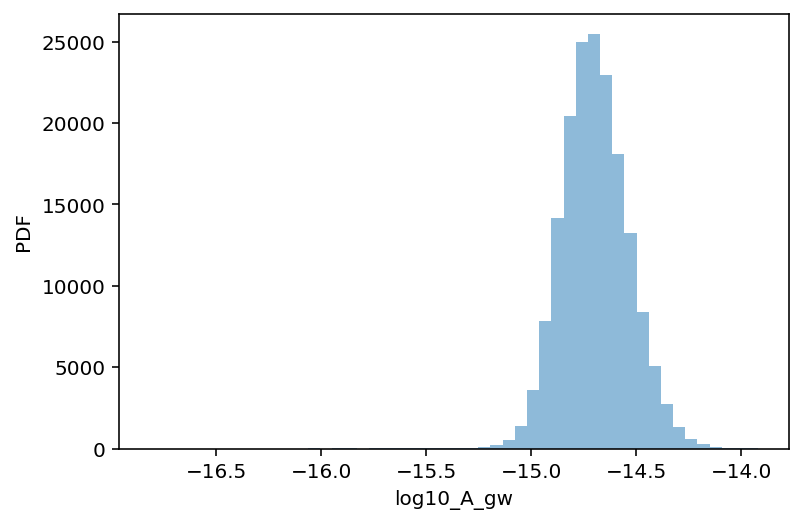

In [39]:
# Plot a histogram of the marginalized posterior distribution
plt.hist(chain[burn:,ind], 50, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5)
plt.xlabel('log10_A_gw')
plt.ylabel('PDF')

## Discussion

* This pulsar clearly supports a common red noise process with a spectral index of $13/3$. The posterior is peaked around a log amplitude of $-14.75$ with low representation below about $-15.5$ and above about $-14.0$. From the dropout analysis in the 12.5 year GWB paper, we can see that `J1909` is the most supportive of this common red noise process.

### Upper limit value

In [38]:
upper = 10**np.percentile(chain[burn:, -5], q=95)
print(upper)

3.7574017586032346e-15


## Now, the easy way to do all of this...

We use `enterprise_extensions` as in the single-pulsar analysis tutorial.

In [114]:
import enterprise_extensions
from enterprise_extensions import models, model_utils, hypermodel

In [115]:
single_pulsar = True

if single_pulsar:
    psrstring = 'J1713'  # name of the pulsar

    parfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'par'), psrstring + '*')))
    timfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'tim'), psrstring + '*')))
else:
    parfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'par'), '*par')))
    timfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'tim'), '*tim')))

# filter
if psrlist is not None:
    parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
    timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile... 
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]

In [116]:
print(parfiles)

['/Users/aaronjohnson/Documents/GitHub/12p5yr_stochastic_analysis/data/par/J1713+0747_NANOGrav_12yv3.gls.t2.par']


In [117]:
psrs = []
ephemeris = 'DE438'
for p, t in zip(parfiles, timfiles):
    psrname = parfiles[0].split('/')[-1].split('_')[0]
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)

In [126]:
pta = models.model_general(psrs, red_psd='powerlaw', common_psd='powerlaw', 
                           red_components=30, common_components=30, 
                           white_vary=False, noisedict=params, tm_svd=True, 
                           gamma_common=4.33, upper_limit_red=True, 
                           upper_limit_common=False, bayesephem=False)

INFO: enterprise.signals.signal_base: Setting J1713+0747_L-wide_ASP_efac to 1.0524302344416032
INFO: enterprise.signals.signal_base: Setting J1713+0747_L-wide_PUPPI_efac to 0.9796026604137508
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr1_2_GASP_efac to 1.084307149708116
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr1_2_GUPPI_efac to 1.017213088587959
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr_800_GASP_efac to 1.117529091199639
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr_800_GUPPI_efac to 1.0500383710337968
INFO: enterprise.signals.signal_base: Setting J1713+0747_S-wide_ASP_efac to 1.1139598766607257
INFO: enterprise.signals.signal_base: Setting J1713+0747_S-wide_PUPPI_efac to 1.0889710082237398
INFO: enterprise.signals.signal_base: Setting J1713+0747_L-wide_ASP_log10_equad to -7.58206720746206
INFO: enterprise.signals.signal_base: Setting J1713+0747_L-wide_PUPPI_log10_equad to -8.377098873197399
INFO: enterprise.signa

In [127]:
# Setup an instance of a HyperModel.
# This doesn't mean we are doing model selection (yet!), but the 
# hypermodel module gives access to some nifty sampling schemes.
super_model = hypermodel.HyperModel({0: pta})

In [128]:
outDir = os.path.join(os.getcwd(), 'chains_pta_test')
sampler = super_model.setup_sampler(resume=False, outdir=outDir, sample_nmodel=False)

Adding red noise prior draws...

Adding GWB uniform distribution draws...



In [129]:
# sampler for N steps
N = int(1e6)
x0 = super_model.initial_sample()

In [130]:
print(pta.params)

[J1713+0747_red_noise_gamma:Uniform(pmin=0, pmax=7), J1713+0747_red_noise_log10_A:LinearExp(pmin=-20, pmax=-11), gw_log10_A:Uniform(pmin=-18, pmax=-14)]


In [131]:
# sample
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Finished 1.00 percent in 22.100442 s Acceptance rate = 0.423533Adding DE jump with weight 50
Finished 99.90 percent in 2268.652731 s Acceptance rate = 0.514159
Run Complete


In [134]:
# Read in chains and parameters

chain = np.loadtxt(outdir + '/chain_1.txt')
burn = int(0.25*chain.shape[0])
pars = np.loadtxt(outdir + '/pars.txt', dtype=np.unicode_)

pp = model_utils.PostProcessing(chain, pars)

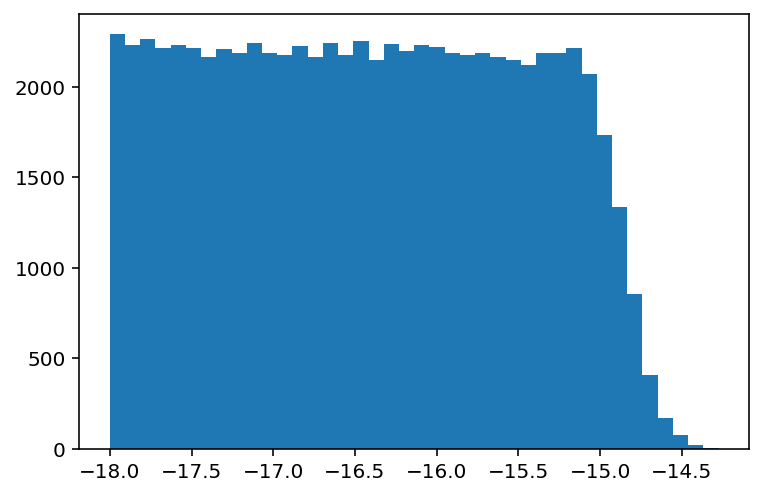

In [135]:
# Plot GW amplitude posterior
ind = list(pars).index('gw_log10_A')
plt.hist(chain[burn:,ind], bins=40);

## Discussion

* `1713` does not favor a common red noise process with spectral index of $13/3$. The posterior includes any amplitude out to the left in contrast to what you see in `1909` where a small range of values is favored. This can also be seen from the dropout method as discussed in the 12.5 year paper. `1713` is the only pulsar to strongly disfavor the common red noise signal.

In [137]:
# Compute upper limit
print(model_utils.ul(chain[burn:, ind], q=95.0))

(1.0504534520671638e-15, 1.0177324273709996e-17)


# PTA Model Selection

We want to be able to compute the Bayesian odds for a GWB in the data. This can be done using the hypermodel class, where we choose between a model with a common (but uncorrelated) red process in the pulsars, and a GWB affecting all pulsars.

We typically perform detection-type analyses with uniform-in-log priors on all amplitude parameters for low-frequency processes. This is implemented below whenever we switch `upper_limit` to be equal to `False`.

## Setup dictionary of PTA models

In [138]:
nmodels = 2
mod_index = np.arange(nmodels)

# Make dictionary of PTAs.
pta = dict.fromkeys(mod_index)
pta[0] = models.model_general(psrs, red_psd='powerlaw', common_psd='powerlaw', 
                           red_components=30, common_components=30, 
                           white_vary=False, noisedict=params, tm_svd=True, 
                           gamma_common=4.33, upper_limit_red=False, 
                           upper_limit_common=False, bayesephem=True, orf=None)
pta[1] = models.model_general(psrs, red_psd='powerlaw', common_psd='powerlaw', 
                           red_components=30, common_components=30, 
                           white_vary=False, noisedict=params, tm_svd=True, 
                           gamma_common=4.33, upper_limit_red=False, 
                           upper_limit_common=False, bayesephem=True, orf='hd')

INFO: enterprise.signals.signal_base: Setting J1713+0747_L-wide_ASP_efac to 1.0524302344416032
INFO: enterprise.signals.signal_base: Setting J1713+0747_L-wide_PUPPI_efac to 0.9796026604137508
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr1_2_GASP_efac to 1.084307149708116
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr1_2_GUPPI_efac to 1.017213088587959
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr_800_GASP_efac to 1.117529091199639
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr_800_GUPPI_efac to 1.0500383710337968
INFO: enterprise.signals.signal_base: Setting J1713+0747_S-wide_ASP_efac to 1.1139598766607257
INFO: enterprise.signals.signal_base: Setting J1713+0747_S-wide_PUPPI_efac to 1.0889710082237398
INFO: enterprise.signals.signal_base: Setting J1713+0747_L-wide_ASP_log10_equad to -7.58206720746206
INFO: enterprise.signals.signal_base: Setting J1713+0747_L-wide_PUPPI_log10_equad to -8.377098873197399
INFO: enterprise.signa

In [146]:
super_model = model_utils.HyperModel(pta)

AttributeError: module 'enterprise_extensions.model_utils' has no attribute 'HyperModel'

## Sample

In [ ]:
sampler = super_model.setup_sampler(resume=False, outdir=outdir, sample_nmodel=True)

In [ ]:
# sampler for N steps
N = int(5e6)
x0 = super_model.initial_sample()

In [ ]:
# sample
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

## Post-process

In [ ]:
chain = np.loadtxt(outdir + '/chain_1.txt')
burn = int(0.25*chain.shape[0])
pars = np.loadtxt(outdir + '/pars.txt', dtype=np.unicode_)

pp = model_utils.PostProcessing(chain, pars)

In [ ]:
# Plot histgram for GW amplitude
chain_burn = chain[burn:,:]

ind_model = list(pars).index('nmodel')
ind_gwamp = list(pars).index('log10_A_gw')

# ORF = None
#plt.hist(chain_burn[chain_burn[:, ind_model] < 0.5, ind_gwamp], bins=40);

# ORF = Hellings & Downs
plt.hist(chain_burn[chain_burn[:, ind_model] > 0.5, ind_gwamp], bins=40);

In [ ]:
# Plot histogram for GWB model selection
plt.hist(chain_burn[:, ind_model], bins=40);

## Bayes factors

### Savage-Dickey Bayes factor

This gives the signal-vs-noise Bayes factor for a common red process in the pulsars plus intrisnc noise, versus intrinsic noise alone.

In [ ]:
print(model_utils.bayes_fac(chain_burn[chain_burn[:, ind_model] < 0.5, ind_gwamp], ntol=1))

### Posterior odds ratio

This gives the Bayesian odds between a model with a Hellings & Downs correlated red process between pulsars, and a common (but uncorrelated) red process between pulsars. This is the smoking-gun detection statsitic for a GWB signal.

In [ ]:
print(model_utils.odds_ratio(chain_burn[:, ind_model], models=[0,1]))